
[Aşama 1/4] Kaydedilmiş ensemble modeli bulunamadı. Eğitim başlıyor...
Eğitim verisi yükleniyor: hog_color_lbp_glcm_augmented_train_kucuk_2class.pkl
Test verisi yükleniyor: hog_color_lbp_glcm_augmented_test_kucuk_2class.pkl
Sınıflar: ['bird' 'drone']

PCA sonrası yeni öznitelik boyutu: 1794

[Aşama 2/4] En iyi bilinen parametrelerle modeller oluşturuluyor ve eğitiliyor...

--- Bireysel Model (SVM) TÜM Eğitim Verisiyle Eğitiliyor ---

--- BİREYSEL MODEL (SVM) DEĞERLENDİRME RAPORU ---
              precision    recall  f1-score   support

        bird       0.96      0.89      0.92       570
       drone       0.95      0.98      0.96      1128

    accuracy                           0.95      1698
   macro avg       0.95      0.94      0.94      1698
weighted avg       0.95      0.95      0.95      1698


--- Bireysel Model (MLP) TÜM Eğitim Verisiyle Eğitiliyor ---

--- BİREYSEL MODEL (MLP) DEĞERLENDİRME RAPORU ---
              precision    recall  f1-score   support

        bird    

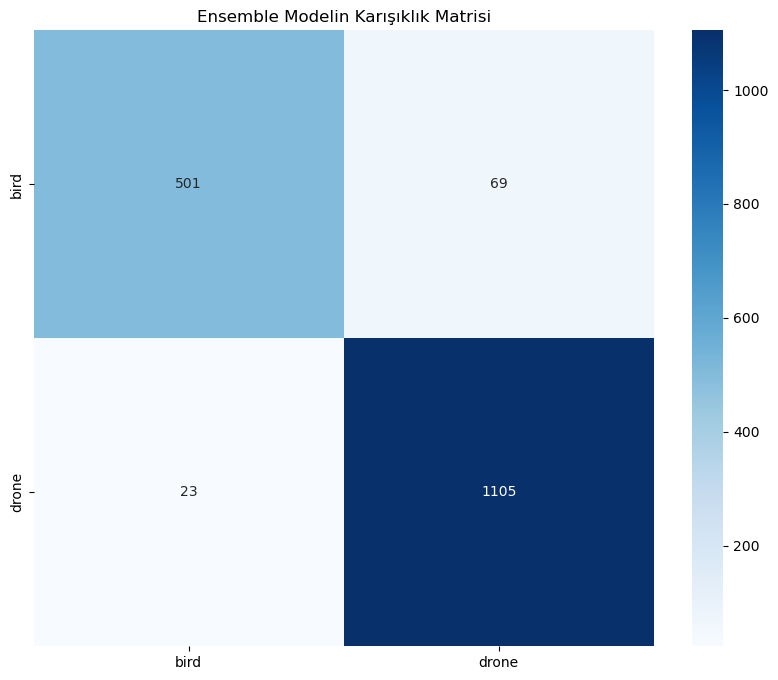


[Aşama 4/4] Ensemble modeli için en iyi güven eşikleri hesaplanıyor...
'bird' sınıfı için optimal eşik (Max F1): 0.1406
'drone' sınıfı için optimal eşik (Max F1): 0.8576

Ensemble modeli ve yardımcılar 'ensemble_model_kucuk_2class.pkl' dosyasına kaydediliyor...

Tespit aşaması başlıyor...
Piramit Katmanı 1, Ölçek: 1.00, Boyut: (1024, 1024)


Katman 1 taranıyor: 361it [00:39,  9.03it/s]


Piramit Katmanı 2, Ölçek: 1.50, Boyut: (682, 682)


Katman 2 taranıyor: 144it [00:15,  9.30it/s]


Piramit Katmanı 3, Ölçek: 2.26, Boyut: (454, 454)


Katman 3 taranıyor: 49it [00:05,  9.27it/s]


Piramit Katmanı 4, Ölçek: 3.39, Boyut: (302, 302)


Katman 4 taranıyor: 16it [00:01,  9.27it/s]


Piramit Katmanı 5, Ölçek: 5.09, Boyut: (201, 201)


Katman 5 taranıyor: 4it [00:00,  9.32it/s]


Piramit Katmanı 6, Ölçek: 7.64, Boyut: (134, 134)


Katman 6 taranıyor: 1it [00:00,  9.56it/s]


Toplam 574 adet potansiyel nesne tespit edildi.

Sonuçlar filtreleniyor ve görselleştiriliyor...
Filtreleme sonrası 152 adet nesne kaldı.


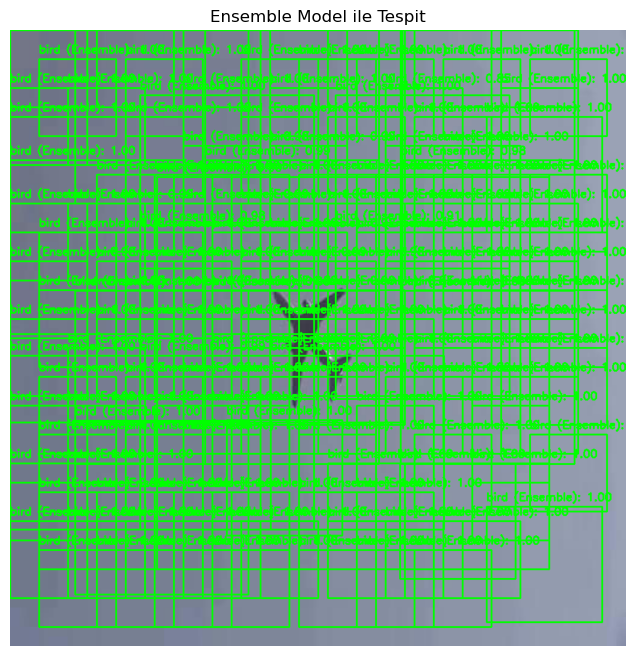



Proje başarıyla tamamlandı!


In [ ]:
import joblib
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os


TRAIN_FEATURES_FILE = 'hog_color_lbp_glcm_augmented_train_kucuk_2class.pkl'
TEST_FEATURES_FILE = 'hog_color_lbp_glcm_augmented_test_kucuk_2class.pkl'
TEST_IMAGE_PATH = "test_goruntusu.jpg"
ENSEMBLE_MODEL_FILE = 'ensemble_model_kucuk_2class.pkl'

BINS = 8
LBP_POINTS = 24
LBP_RADIUS = 8
GLCM_DISTANCES = [1, 2]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GLCM_PROPERTIES = ['energy', 'contrast', 'homogeneity', 'correlation']
GLCM_LEVELS = 32

def extract_color_histogram(image, bins=(BINS, BINS, BINS)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(gray_image):
    lbp = local_binary_pattern(gray_image, LBP_POINTS, LBP_RADIUS, method="uniform")
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), range=(0, LBP_POINTS + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    return lbp_hist

def extract_glcm_features(gray_image):
    img_for_glcm = (gray_image / 255.0 * (GLCM_LEVELS - 1)).astype(np.uint8)
    glcm = graycomatrix(img_for_glcm, GLCM_DISTANCES, GLCM_ANGLES, levels=GLCM_LEVELS, symmetric=True, normed=True)
    glcm_features = [graycoprops(glcm, prop).flatten() for prop in GLCM_PROPERTIES]
    return np.concatenate(glcm_features)

def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def pyramid(image, scale=1.5, minSize=(128, 128)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w, int(image.shape[0] * (w / float(image.shape[1])))))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image


if not os.path.exists(ENSEMBLE_MODEL_FILE):
    print(f"\n[Aşama 1/4] Kaydedilmiş ensemble modeli bulunamadı. Eğitim başlıyor...")
    
    # --- 1. Veri Yükleme ve Hazırlama ---
    print(f"Eğitim verisi yükleniyor: {TRAIN_FEATURES_FILE}")
    train_data = joblib.load(TRAIN_FEATURES_FILE)
    X_train, y_train_text = train_data['features'], train_data['labels']

    print(f"Test verisi yükleniyor: {TEST_FEATURES_FILE}")
    test_data = joblib.load(TEST_FEATURES_FILE)
    X_test, y_test_text = test_data['features'], test_data['labels']

    le = LabelEncoder()
    le.fit(np.concatenate((y_train_text, y_test_text)))
    y_train = le.transform(y_train_text)
    y_test = le.transform(y_test_text)
    class_names = le.classes_
    print(f"Sınıflar: {class_names}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"\nPCA sonrası yeni öznitelik boyutu: {pca.n_components_}")

    
    print("\n[Aşama 2/4] En iyi bilinen parametrelerle modeller oluşturuluyor ve eğitiliyor...")
    
    best_params = {
        'SVM': {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf', 'probability': True, 'random_state': 42},
        'MLP': {'hidden_layer_sizes': (100,), 'alpha': 0.01, 'max_iter': 500, 'random_state': 42},
        'XGBoost': {'n_estimators': 200, 'learning_rate': 0.1, 'eval_metric': 'mlogloss', 'random_state': 42}
    }

    estimators = [
        ('SVM', SVC(**best_params['SVM'])),
        ('MLP', MLPClassifier(**best_params['MLP'])),
        ('XGBoost', XGBClassifier(**best_params['XGBoost']))
    ]

  
    for name, model in estimators:
        print(f"\n--- Bireysel Model ({name}) TÜM Eğitim Verisiyle Eğitiliyor ---")
        model.fit(X_train_pca, y_train)
        print(f"\n--- BİREYSEL MODEL ({name}) DEĞERLENDİRME RAPORU ---")
        y_pred = model.predict(X_test_pca)
        print(classification_report(y_test, y_pred, target_names=class_names))
  

    print("\n[Aşama 3/4] En iyi modeller birleştirilerek Ensemble modeli oluşturuluyor...")
    ensemble_model = VotingClassifier(estimators=estimators, voting='soft')
    ensemble_model.fit(X_train_pca, y_train)
    
    print("\n--- ENSEMBLE MODEL DEĞERLENDİRME RAPORU ---")
    y_pred_ensemble = ensemble_model.predict(X_test_pca)
    print(classification_report(y_test, y_pred_ensemble, target_names=class_names))
    
    
    conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Ensemble Modelin Karışıklık Matrisi')
    plt.show()

    print("\n[Aşama 4/4] Ensemble modeli için en iyi güven eşikleri hesaplanıyor...")
    y_probas = ensemble_model.predict_proba(X_test_pca)
    optimal_thresholds = {}
    for i, class_name in enumerate(class_names):
        precision, recall, thresholds = precision_recall_curve(y_test, y_probas[:, i], pos_label=i)
        f1_scores = np.nan_to_num(2 * recall[:-1] * precision[:-1] / (recall[:-1] + precision[:-1]))
        if len(f1_scores) > 0:
            best_f1_idx = np.argmax(f1_scores)
            optimal_thresholds[class_name] = thresholds[best_f1_idx]
        else:
            optimal_thresholds[class_name] = 0.5
        print(f"'{class_name}' sınıfı için optimal eşik (Max F1): {optimal_thresholds[class_name]:.4f}")

    print(f"\nEnsemble modeli ve yardımcılar '{ENSEMBLE_MODEL_FILE}' dosyasına kaydediliyor...")
    joblib.dump({
        'model': ensemble_model, 'scaler': scaler, 'pca': pca, 
        'le': le, 'class_names': class_names, 'thresholds': optimal_thresholds
    }, ENSEMBLE_MODEL_FILE)

else:
    print(f"\nKaydedilmiş '{ENSEMBLE_MODEL_FILE}' dosyası bulundu. Model doğrudan yükleniyor.")

if 'ensemble_model' not in locals():
    saved_data = joblib.load(ENSEMBLE_MODEL_FILE)
    ensemble_model, scaler, pca, le, class_names, optimal_thresholds = \
        saved_data['model'], saved_data['scaler'], saved_data['pca'], \
        saved_data['le'], saved_data['class_names'], saved_data['thresholds']


print("\nTespit aşaması başlıyor...")

(winW, winH) = (128, 128)
step_size = 48
image = cv2.imread(TEST_IMAGE_PATH)
if image is None: print(f"HATA: Test görüntüsü '{TEST_IMAGE_PATH}' yüklenemedi."); exit()
clone = image.copy()
detections = []

PIXELS_PER_CELL, CELLS_PER_BLOCK, ORIENTATIONS = (8, 8), (2, 2), 9

for i, resized in enumerate(pyramid(image, scale=1.5)):
    scale_factor = image.shape[1] / float(resized.shape[1])
    print(f"Piramit Katmanı {i+1}, Ölçek: {scale_factor:.2f}, Boyut: {resized.shape[:2]}")
    for (x, y, window) in tqdm(sliding_window(resized, step_size=step_size, window_size=(winW, winH)), desc=f"Katman {i+1} taranıyor"):
        if window.shape[0] != winH or window.shape[1] != winW: continue
        
        color_window = window
        gray_window = cv2.cvtColor(color_window, cv2.COLOR_BGR2GRAY)
        
        hog_features = hog(gray_window, orientations=ORIENTATIONS, pixels_per_cell=PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, block_norm='L2-Hys')
        color_features = extract_color_histogram(color_window)
        lbp_features = extract_lbp_features(gray_window)
        glcm_features = extract_glcm_features(gray_window)
        
        combined_features = np.concatenate([hog_features, color_features, lbp_features, glcm_features])
        features_scaled = scaler.transform([combined_features])
        features_pca = pca.transform(features_scaled)

        pred_proba_all_classes = ensemble_model.predict_proba(features_pca)[0]
        predicted_class_index = np.argmax(pred_proba_all_classes)
        max_proba = pred_proba_all_classes[predicted_class_index]
        class_label = class_names[predicted_class_index]
        
        confidence_threshold = optimal_thresholds.get(class_label, 0.99)
        
        if max_proba > confidence_threshold: 
            if class_label in ['bird', 'drone']:
                startX, startY = int(x * scale_factor), int(y * scale_factor)
                endX, endY = int((x + winW) * scale_factor), int((y + winH) * scale_factor)
                box = (startX, startY, endX, endY)
                detections.append((box, max_proba, class_label, "Ensemble")) 

print(f"Toplam {len(detections)} adet potansiyel nesne tespit edildi.")

print("\nSonuçlar filtreleniyor ve görselleştiriliyor...")
final_detections = []
detections.sort(key=lambda d: d[1], reverse=True) 
while len(detections) > 0:
    best_detection = detections.pop(0)
    final_detections.append(best_detection)
    (box1, _, _, _) = best_detection
    remaining_detections = []
    for other_detection in detections:
        (box2, _, _, _) = other_detection
        (x1_a, y1_a, x2_a, y2_a) = box1
        (x1_b, y1_b, x2_b, y2_b) = box2
        xA, yA = max(x1_a, x1_b), max(y1_a, y1_b)
        xB, yB = min(x2_a, x2_b), min(y2_a, y2_b)
        interArea = max(0, xB - xA) * max(0, yB - yA)
        if interArea == 0:
            remaining_detections.append(other_detection)
            continue
        boxAArea = (x2_a - x1_a) * (y2_a - y1_a)
        boxBArea = (x2_b - x1_b) * (y2_b - y1_b)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        if iou < 0.3: 
            remaining_detections.append(other_detection)
    detections = remaining_detections

print(f"Filtreleme sonrası {len(final_detections)} adet nesne kaldı.")

model_colors = {'Ensemble': (0, 255, 0)}

for (box, proba, label, model_name) in final_detections:
    (startX, startY, endX, endY) = box
    color = model_colors.get(model_name, (255, 255, 255)) 
    cv2.rectangle(clone, (startX, startY), (endX, endY), color, 2)
    label_text = f"{label} ({model_name}): {proba:.2f}"
    cv2.putText(clone, label_text, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.title("Ensemble Model ile Tespit")
plt.axis('off')
plt.show()

print("\n\nProje başarıyla tamamlandı!")